In [1]:
import torch
from torch import nn

import matplotlib.pyplot as plt

In [2]:
print(torch.__version__)

2.0.1+cu117


In [3]:
torch.manual_seed(111)

In [75]:
# Differentiable Augmentation for Data-Efficient GAN Training
# Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu, and Song Han
# https://arxiv.org/pdf/2006.10738

import torch
import torch.nn.functional as F


def DiffAugment(x, policy='', channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2).contiguous()
    return x


def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

In [76]:
device = ""
if torch.cuda.is_available():
    print('cuda available')
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device = torch.device("cpu")

cuda available


In [77]:
from PIL import Image, ImageFont, ImageDraw
import numpy as np
import pandas as pd
import os


In [78]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.empty_cache())

2.0.1+cu117
True
None


In [79]:
# setting device on GPU if available, else CPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cpu



In [80]:
root_data_folder = "8bit_characters"
image_names = [root_data_folder + "/" + name for name in os.listdir(root_data_folder) if name.endswith(".jpg")]
print(image_names)

['8bit_characters/leonardo_5935302653_o.jpg', '8bit_characters/mysterio_5938497845_o.jpg', '8bit_characters/john-bender_5947476192_o.jpg', '8bit_characters/wheeljack_5982213732_o.jpg', '8bit_characters/spikor_5921532302_o.jpg', '8bit_characters/samus-aran-power-suit_6024447687_o.jpg', '8bit_characters/allison-reynolds_5947475934_o.jpg', '8bit_characters/calypso_5994982128_o.jpg', '8bit_characters/michaelangelo_5935302777_o.jpg', '8bit_characters/neytiri_5925081796_o.jpg', '8bit_characters/mortimer-shadow_5994422753_o.jpg', '8bit_characters/iceman_5938072442_o.jpg', '8bit_characters/lobot_5930961478_o.jpg', '8bit_characters/krista-sparks-grasshopper_5994422531_o.jpg', '8bit_characters/pee-wee-herman_5942000962_o.jpg', '8bit_characters/leeloo_5935305091_o.jpg', '8bit_characters/bamm-bamm_5991957878_o.jpg', '8bit_characters/arwen_5955334313_o.jpg', '8bit_characters/bride-of-frankenstien_5939327360_o.jpg', '8bit_characters/samwise-gamgee_5955895448_o.jpg', '8bit_characters/smitty_595463830

In [81]:
def get_df_rgb(img):
    image = img
    if isinstance(img, str):
        image = Image.open(img)
    
    n_dims = np.array(image).shape[-1]
    r, g, b = np.array(image).reshape(-1, n_dims).T
    # return pd.DataFrame({'r': r, 'g': g, 'b': b}).sample(n=sample_size)
    return pd.DataFrame({'r': r, 'g': g, 'b': b})

Custom data loader image: https://www.topbots.com/step-by-step-implementation-of-gans-part-2/

In [82]:
X_train = []
count = 0
for dir in image_names:
    try: 
        pixel_size = 50
        img = Image.open(dir)
        img = img.convert("RGB")
        temp = []
        for i in range(0, img.size[0], int(pixel_size/5)):
            row = []
            for j in range(0, img.size[1], int(pixel_size/5)):
                row.append(img.getpixel((j, i)))
            temp.append(row)
        img = np.asarray(temp)/255
        X_train.append(img)
        count += 1
    except Exception as e:
        print(count)
        print(e)

We must augment data because there is not much data

In [83]:
def plot_images(imgs, grid_size = 5):
    """
    imgs: vector containing all the numpy images
    grid_size: 2x2 or 5x5 grid containing images
    """
     
    fig = plt.figure(figsize = (8, 8))
    columns = rows = grid_size
    plt.title("Training Images")

    for i in range(1, columns*rows +1):
        plt.axis("off")
        fig.add_subplot(rows, columns, i)
        if i >= len(imgs):
            break
        plt.imshow(imgs[i])
    plt.show()
    plt.close()

In [84]:
def plot_single_image(img):
    plt.imshow(img)
    plt.show()

In [85]:
# from skimage import color

# def filter_dataset(train):
#     """
#     Filter dataset to only include images with black eyes
#     """
#     eye_indices = [[4,11], [5,11]]
#     filtered_train = []

#     for sample in train:
#         is_sample_valid = True
#         for indice in eye_indices:
#             lab = color.rgb2lab(sample[indice[0]][indice[1]])
#             l = lab[0] 
#             a = lab[1] 
#             b = lab[2] 
#             # we will color the eyes as pitch black
#             if not (a <= 2 and b <= 2 and l <= 25):
#                 is_sample_valid = False
#         if is_sample_valid:
#             for eye in eye_indices:
#                 sample[eye[0]][eye[1]][0] = 0
#                 sample[eye[0]][eye[1]][1] = 0
#                 sample[eye[0]][eye[1]][2] = 0
#             filtered_train.append(sample)

#     return filtered_train


In [86]:
# X_train = filter_dataset(X_train)
# print(len(X_train))

In [87]:
import torchvision
from torchvision import transforms

trans = transforms.ToPILImage() 

def augment_images(train, augment_by):
    # we will only change hue
    aug = torchvision.transforms.ColorJitter(hue=0.5)
    augmented_train = []
    for data in train:
        augmented_train.append(data)
        image = Image.fromarray(np.uint8(data*255))
        Y = [aug(image) for _ in range(augment_by)]
        for y in Y:
            augmented_train.append(np.asarray(y)/255)
    return augmented_train


In [88]:
# lab_train = color.rgb2lab(X_train)
# # We will jitter by lab since we do not want to change the luminance
# def jitter_lab(lab, jitter_amount = 5, augment_by = 50):
#     """
#     lab: numpy array containing lab values
#     jitter_amount: amount to jitter by
#     """
#     samples = []
#     count = 0
#     count_real = 0 
#     for sample in lab:
#         new_sample = np.zeros((len(sample), len(sample[0]), 3))
#         color_palette = {}
#         count_real += 2
#         for i in range(len(sample)):
#             for j in range(len(sample[i])):
#                 color = sample[i][j]
#                 l = int(color[0])
#                 a = int(color[1])
#                 b = int(color[2])
#                 new_sample[i][j][0] = l
#                 new_sample[i][j][1] = a
#                 new_sample[i][j][2] = b
#                 if l >= 90 and abs(a) <= 0.2 and abs(b) <= 0.2:
#                     continue
#                 if l == 0 and abs(a) == 0 and abs(b) == 0:
#                     continue
#                 palette = f'{l}_{a}_{b}'
#                 if palette not in color_palette:
#                     color_palette[palette] = [[i, j]]
#                 else:
#                     color_palette[palette].append([i, j])
#         # we add original
#         samples.append(sample)
      
        
#         for j in range(augment_by):
#             j_sample = np.copy(new_sample)
#             for palette in color_palette:
#                 lab_split = palette.split("_")
#                 indices_to_color = color_palette[palette]
#                 l = int(lab_split[0])
#                 a = int(lab_split[1])
#                 b = int(lab_split[2])
#                 jitter_a = np.random.randint(a - jitter_amount, a + jitter_amount)
#                 if jitter_a < -128:
#                     jitter_a = -128
#                 elif jitter_a >= 127:
#                     jitter_a = 127
#                 jitter_b = np.random.randint(b - jitter_amount, b + jitter_amount)
#                 if jitter_b < -128:
#                     jitter_b = -128
#                 elif jitter_b >= 127:
#                     jitter_b = 127
#                 for idx in indices_to_color:
#                     j_sample[idx[0]][idx[1]][1] = jitter_a
#                     j_sample[idx[0]][idx[1]][2] = jitter_b
#             samples.append(np.asarray(j_sample))
#     return np.array(samples)
            

In [89]:
X_train = np.array(X_train)
X_train.shape

(701, 50, 50, 3)

In [90]:
from numpy import savez_compressed

# savez_compressed('8bit_characters_50x50.npz', X_train)

In [91]:
dict_data = np.load('8bit_characters_50x50.npz')
 
# extract the first array
data = dict_data['arr_0']
 
# print the array
# print(data)

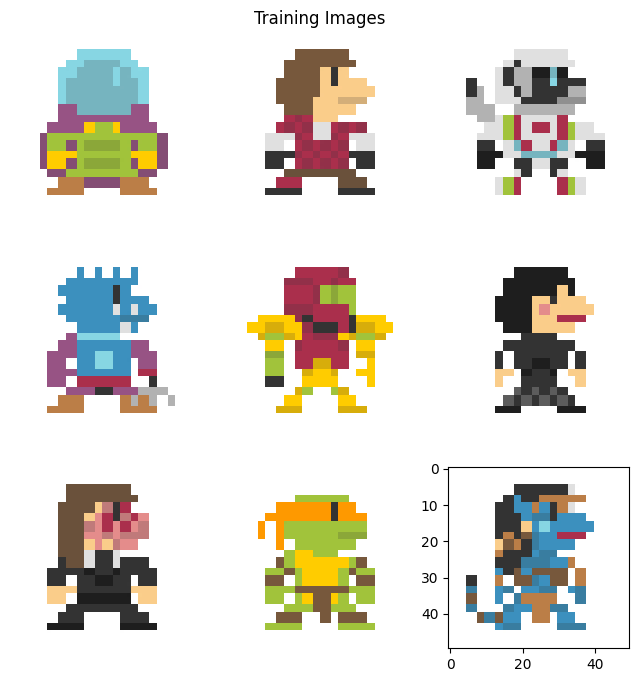

In [92]:
imgs = np.load('8bit_characters_50x50.npz')
 
# pls ignore the poor quality of the images as we are working with 32x32 sized images.
plot_images(imgs['arr_0'], 3)

In [93]:
from torch.utils.data import Dataset, DataLoader

class PixelCharacterDataset(Dataset):
    """Human Faces dataset."""
 
    def __init__(self, npz_imgs):
        """
        Args:
            npz_imgs (string): npz file with all the images (created in gan.ipynb)
        """
        self.imgs = npz_imgs
 
    def __len__(self):
        return len(self.imgs)
 
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
 
        image = self.imgs[idx]
 
        return image

In [94]:
transpose_imgs = np.transpose(
    np.float32(imgs['arr_0']), (0, 3, 1, 2)
)
dset = PixelCharacterDataset(transpose_imgs)

dataloader = DataLoader(dset, batch_size=32, shuffle=True)

In [95]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # input to generator is something like (batch_size, 100, 1, 1)
        # this means that we are passing a batch of 32 100 random numbers to the generator
        self.model = nn.Sequential(
            # why is in_channels 100?
            # because we are passing 100 random numbers to the generator
            # our latent space is 100 dimensional!
            # first our input is (batch_size, 100, 1, 1)
            # step size is always 1!
            nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=5, stride=2, padding=0, bias=False),
            # the output of this layer is (batch_size, 512, 5, 5)
            # this is because of the formula for calculating the output size of the image
            # dilation is 1 by default
            # H_out = (H_in - 1) * stride - 2 * padding + dilation[0] * (kernel_size[0] - 1) + output_padding + 1
    #                     H_in(1),stride(2),pad(0),kernel(5),output_pad(0)
            # in here, 5 = (1–1) * 2 – 2 * 0 + 1 * (5 –1) + 0 + 1 = 5
            nn.BatchNorm2d(512),
            nn.ReLU(),

            # what is passed here is (batch_size, 512, 4, 4)
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=0, bias=False),
            # this is because of the formula for calculating the output size of the image
            # H_out = (H_in - 1) * stride - 2 * padding + dilation[0] * (kernel_size[0] - 1) + output_padding + 1
            # H_out = (5    - 1) * 2      - 2 * 0       + 1           * (4              - 1) + 0              + 1
            # H_out = 4 * 2 - 0 + 3 + 1 = 12
            nn.BatchNorm2d(256),
            nn.ReLU(),
        

            # what is passed here is (batch_size, 256, 8, 8)
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=5, stride=2, padding=1, bias=False),
            # the output of this layer is (batch_size, 128, 16, 16)
            # this is because of the formula for calculating the output size of the image
            # H_out = (H_in - 1) * stride - 2 * padding + dilation[0] * (kernel_size[0] - 1) + output_padding + 1
            # H_out = (12    - 1) * 2      - 2 * 1       + 1           * (5              - 1) + 0              + 1
            # H_out = 11 * 2 - 2 + 4 + 1 = 25
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            # the output of this layer is (batch_size, 64, 32, 32)
            # this is because of the formula for calculating the output size of the image
            # H_out = (H_in - 1) * stride - 2 * padding + dilation[0] * (kernel_size[0] - 1) + output_padding + 1
            # H_out = (25    - 1) * 2      - 2 * 1       + 1           * (4              - 1) + 0              + 1
            # H_out = 24 * 2 - 2 + 3 + 1 = 50
            nn.Tanh(),
        )

    def forward(self, x):
        return self.model(x)


In [96]:
# test if the wanted dimensions are correct

class ExampleGenerator(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 5, 2, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 5, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.gen(x)
    
ex_gen = ExampleGenerator()
t = torch.randn(32, 100, 1, 1)
output = ex_gen(t)

print(output.shape)
print(output.type())



torch.Size([32, 64, 50, 50])
torch.FloatTensor


In [97]:
class Discriminator(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.model = nn.Sequential(
            # input is (3, 50, 50)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            # H_out = (H_in + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1
            # H_out = (50    + 2 * 1       - 1        * (4           - 1) - 1) / 2      + 1
            # H_out = (52   - 3           - 1) / 2 + 1
            # H_out = 25
            # output is (32, 25, 25)
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=32, out_channels=32*2, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32*2),
            nn.LeakyReLU(0.2),
            # H_out = (H_in + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1
            # H_out = (25    + 2 * 1       - 1        * (3           - 1) - 1) / 2      + 1
            # H_out = (27   - 2           - 1) / 2 + 1
            # H_out = 24 / 2 + 1 = 13
            # output is (64, 13, 13)

            nn.Conv2d(in_channels=64, out_channels=32*4, kernel_size=5, stride=2, padding=1, bias=False),
            # H_out = (H_in + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1
            # H_out = (13    + 2 * 1       - 1        * (5           - 1) - 1) / 2      + 1
            # H_out = (15   - 4           - 1) / 2 + 1
            # H_out = 6
            nn.BatchNorm2d(32*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=32*4, out_channels=32*8, kernel_size=2, stride=2, padding=0, bias=False),
            # H_out = (H_in + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1
            # H_out = (6    + 2 * 0       - 1        * (2           - 1) - 1) / 2      + 1
            # H_out = (6   - 1           - 1) / 2 + 1
            # H_out = 2
            nn.BatchNorm2d(32*8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=32*8, out_channels=1, kernel_size=3, stride=1, padding=0, bias=False),
            # H_out = (H_in + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1
            # H_out = (2    + 2 * 0       - 1        * (2           - 1) - 1) / 1      + 1
            # H_out = (2   - 1           - 1) / 1 + 1
            # H_out = 1
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.model(x)
    




In [98]:
ex_dis = Discriminator().to(device)
ex_dis(torch.randn(32, 3, 50, 50).to(device)).shape


torch.Size([32, 1, 1, 1])

In [99]:
def init_weights(m):
    if type(m) == nn.ConvTranspose2d:
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [100]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(init_weights)
discriminator.apply(init_weights)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [101]:
lr = 0.001 # learning rate
num_epochs = 5 # number of epochs
def backward_hook(grad):
    print(grad)
loss_function = nn.BCELoss() # Binary Cross Entropy Loss (since we are doing binary classification - whether the data is real or fake)


In [102]:
# We will use Adam optimizer
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

In [103]:
for data in dataloader:
    print(data.shape)
    print(data)
    break

torch.Size([32, 3, 50, 50])
tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,

In [120]:
diff_policy='color,cutout'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


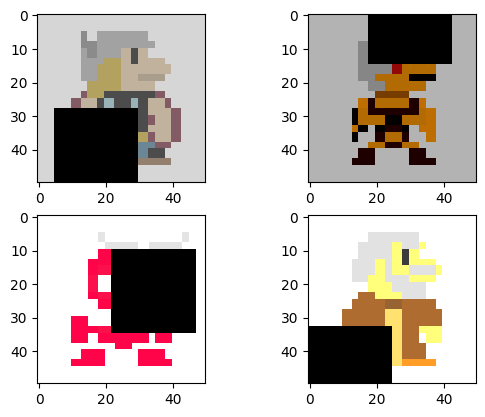

In [125]:
# Visualize images from dataset with diff augmentation
for batch in dataloader:
    for i in range(4):
        plt.subplot(2, 2, i+1)
        # print(batch.shape)
        # DiffAugment(batch, policy='color,translation,cutout')
        transformed = DiffAugment(batch, policy=diff_policy)
        plt.imshow(np.transpose(transformed[i], (1,2,0)))
    break
# plt.show()

In [126]:
for n in enumerate(dataloader):
    print(len(n))
    break

2


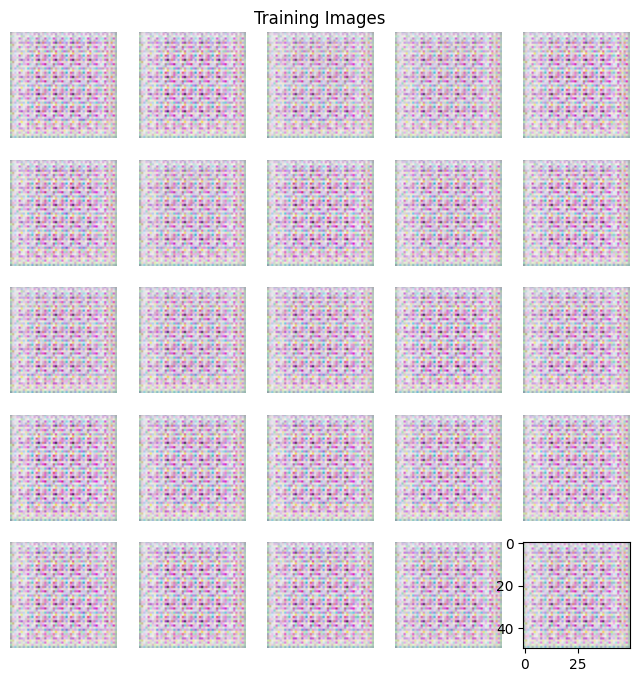

********************
 Epoch 0 and iteration 0 
 Discriminator loss is 0.348976 
 Generator loss is 4.013995 


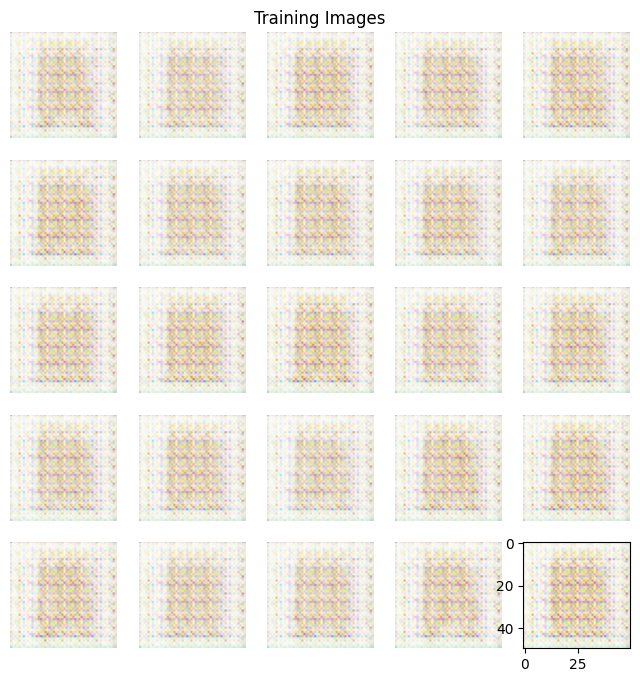

********************
 Epoch 0 and iteration 16 
 Discriminator loss is 0.408660 
 Generator loss is 4.733865 


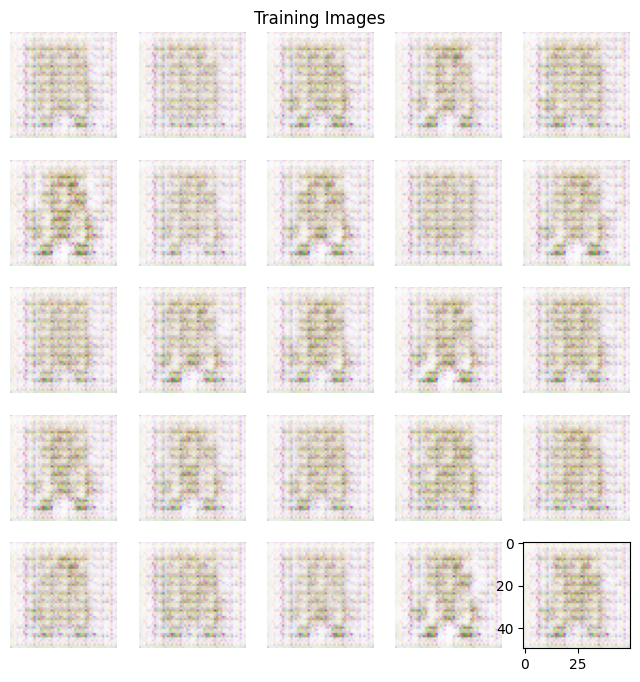

********************
 Epoch 1 and iteration 0 
 Discriminator loss is 1.282391 
 Generator loss is 4.814179 


KeyboardInterrupt: 

In [127]:

# going over the entire dataset 10 times
for e in range(num_epochs):
     
    # pick each batch b of input images: shape of each batch is (32, 3, 32, 32)
    for i, b in enumerate(dataloader):
 
        ##########################
        ## Update Discriminator ##
        ##########################
 
        # Loss on real images
         
        # clear the gradient
        optimizer_discriminator.zero_grad() # set the gradients to 0 at start of each loop because gradients are accumulated on subsequent backward passes
        # compute the D model output
        b_t = DiffAugment(b, policy=diff_policy)
        yhat = discriminator(b_t.to(device)).view(-1) # view(-1) reshapes a 4-d tensor of shape (2,1,1,1) to 1-d tensor with 2 values only
        # specify target labels or true labels
        target = torch.ones(len(b_t), dtype=torch.float, device=device)
        # calculate loss
        loss_real = loss_function(yhat, target)
        # calculate gradients -  or rather accumulation of gradients on loss tensor
        loss_real.backward()
 
        # Loss on fake images
 
        # generate batch of fake images using G
        # Step1: creating noise to be fed as input to G
        noise = torch.randn(len(b_t), 100, 1, 1, device = device)
        # Step 2: feed noise to G to create a fake img (this will be reused when updating G)
        fake_img = generator(noise) 
        fake_img = DiffAugment(fake_img, policy=diff_policy)
 
        # compute D model output on fake images
        yhat = discriminator(fake_img.detach()).view(-1).to(device) # .cuda() is essential because our input i.e. fake_img is on gpu but model isnt (runtimeError thrown); detach is imp: Basically, only track steps on your generator optimizer when training the generator, NOT the discriminator. 
        # specify target labels
        target = torch.zeros(len(b_t), dtype=torch.float, device=device)
        # calculate loss
        loss_fake = loss_function(yhat, target)
        # calculate gradients
        loss_fake.backward()
 
        # total error on D
        loss_disc = loss_real + loss_fake
 
        # Update weights of D
        optimizer_discriminator.step()
 
        ##########################
        #### Update Generator ####
        ##########################
 
        # clear gradient
        optimizer_generator.zero_grad()
        # pass fake image through D
        yhat = discriminator(fake_img).view(-1).to(device)
        # specify target variables - remember G wants D *to think* these are real images so label is 1
        target = torch.ones(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_gen = loss_function(yhat, target)
        # calculate gradients
        loss_gen.backward()
        # update weights on G
        optimizer_generator.step()
 
 
        ####################################
        #### Plot some Generator images ####
        ####################################
 
        # during every epoch, print images at every 10th iteration.
        if i % 16 == 0:
            # convert the fake images from (b_size, 3, 32, 32) to (b_size, 32, 32, 3) for plotting 
            noise = torch.randn(len(b_t), 100, 1, 1, device = device)
            fake_img = generator(noise) 
            img_plot = np.transpose(fake_img.detach().cpu(), (0,2,3,1)) # .detach().cpu() is imp for copying fake_img tensor to host memory first
            img_plot = (img_plot + 1)/2
            plot_images(img_plot)
            print("********************")
            print(" Epoch %d and iteration %d " % (e, i))
            print(" Discriminator loss is %f " % (loss_disc))
            print(" Generator loss is %f " % (loss_gen))